In [29]:
import pandas as pd
import numpy as np

from src.OLS import OLS
from src.StandardScaler import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

# mpl.rcParams['figure.dpi'] = 300

import seaborn as sns

from src.stat_tests import KS2Sample, AR1, BootstrapKS2Samp, VIF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf


def bn_dollar_fmt(x, pos):
    # sign as string
    sign = "" if np.sign(x) >= 0 else "−"
    return f"{sign}${abs(x):,.0f} Bn"

def pct_fmt(x, pos):
    return f"{x:.2%}"

In [30]:
s = StandardScaler()
rgdp = pd.read_csv('./data/fred/GDPC1.csv', low_memory=False, encoding='utf-8')
cpi = pd.read_csv('./data/fred/CPIAUCSL.csv', low_memory=False, encoding='utf-8')
unrate = pd.read_csv('./data/fred/UNRATE.csv', low_memory=False, encoding='utf-8')

set = [rgdp, cpi, unrate]
for df in set:
    df.set_index("observation_date", inplace=True)

rgdp = rgdp.pct_change().dropna()
cpi = cpi.pct_change().dropna()
unrate = unrate.pct_change().dropna()

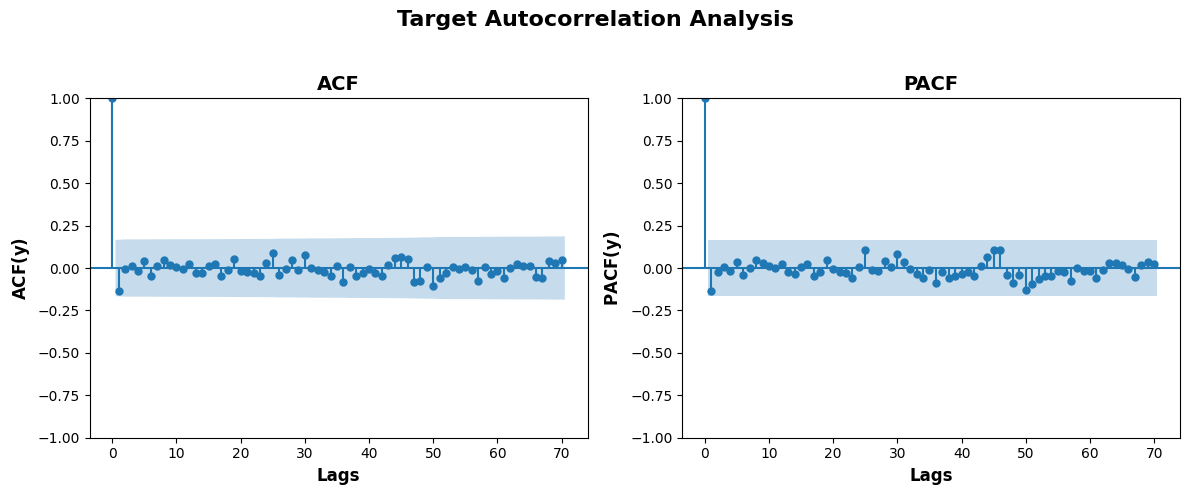

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(rgdp, ax[0], lags=70)
ax[0].set_title(r"ACF", fontsize=14, weight='bold')
ax[0].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[0].set_ylabel(r"$\mathbf{ACF(y)}$", fontsize=12, weight='bold')

plot_pacf(rgdp, ax[1], lags=70)
ax[1].set_title(r"PACF", fontsize=14, weight='bold')
ax[1].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[1].set_ylabel(r"$\mathbf{PACF(y)}$", fontsize=12, weight='bold')
plt.suptitle(r"Target Autocorrelation Analysis", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('./paper/fig/acf_pacf.png', dpi=300)
plt.show()


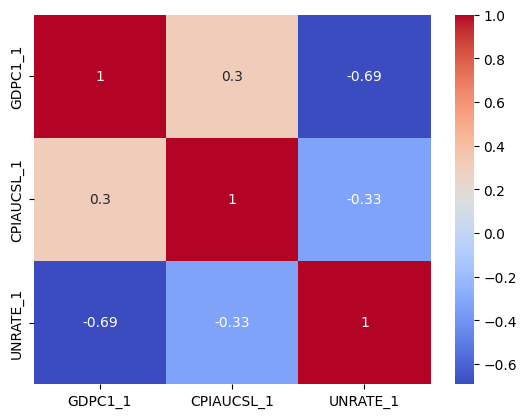

In [32]:
target = pd.Series(rgdp['GDPC1'])
X = pd.concat([rgdp, cpi.loc[rgdp.index], unrate.loc[rgdp.index]], axis=1)
X = X.shift(1).dropna(how='any')
cols = X.columns.tolist()
X.columns = [col + "_1" for col in cols]
X_2 = X.shift(1)

target = target.loc[X.index]
time_idx = target.index

assert X.notna().all().all() == target.notna().all().all() == True, len(X) == len(target)
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')

y = target.values
# X = s.fit_transform(X.values)
X = X.values

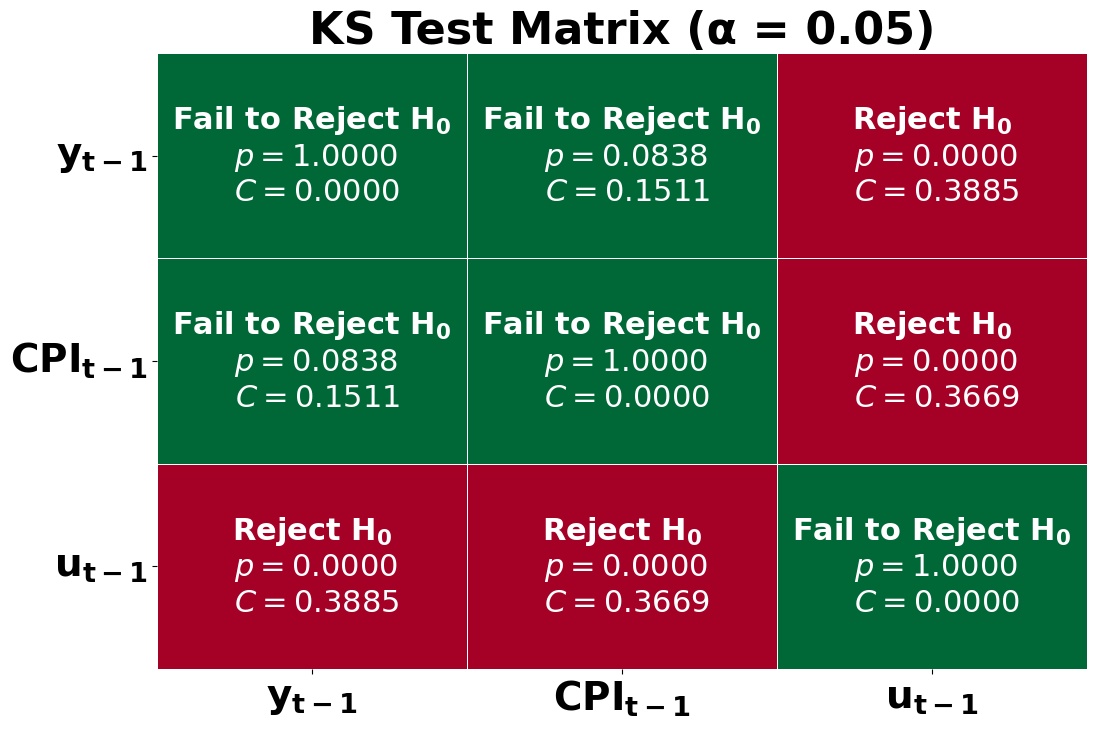

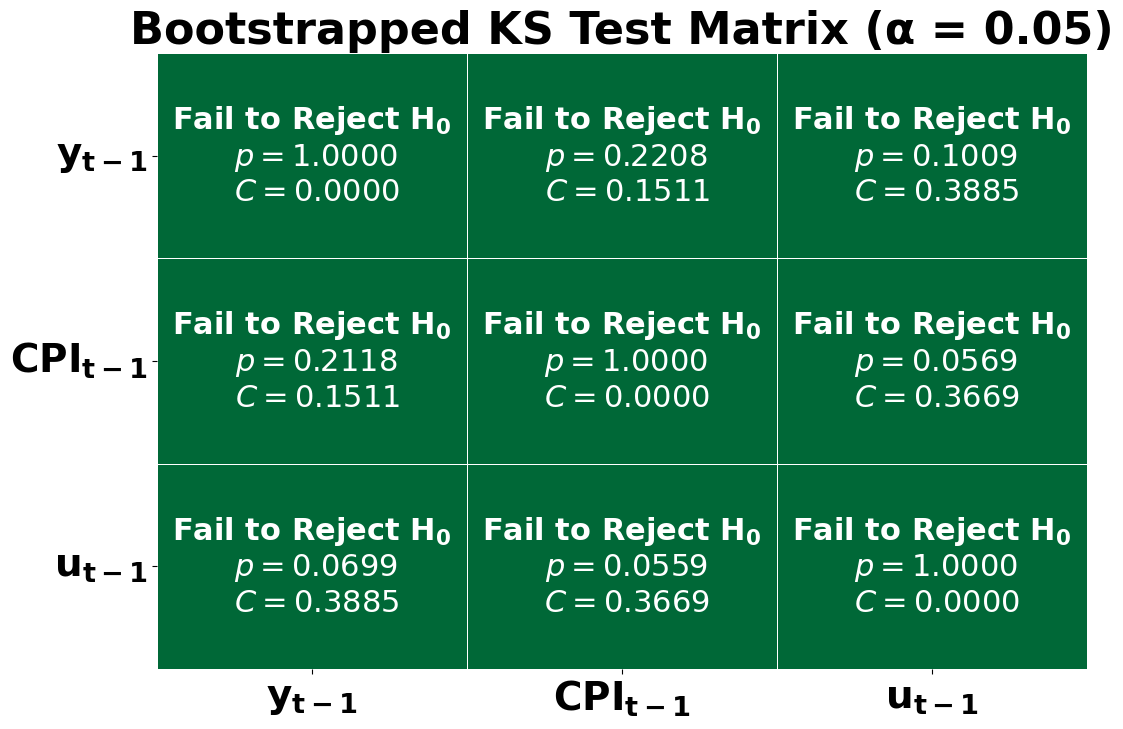

In [33]:
vars = [r"$\mathbf{y_{t-1}}$", r"$\mathbf{CPI_{t-1}}$", r"$\mathbf{u_{t-1}}$"]
tests = KS2Sample(X, display_plot=True, varnames=vars)
bs_tests = BootstrapKS2Samp(X, display_plot=True, n_bootstrap=1000, varnames=vars)

In [34]:
tests[0]

,$\mathbf{y_{t-1}}$,$\mathbf{CPI_{t-1}}$,$\mathbf{u_{t-1}}$
$\mathbf{y_{t-1}}$,0.000000,0.151079,0.388489
$\mathbf{CPI_{t-1}}$,0.151079,0.000000,0.366906
$\mathbf{u_{t-1}}$,0.388489,0.366906,0.000000


In [35]:
VIF(X)

array([1.94085502, 1.13844997, 1.98602305])

In [36]:
u_ar = AR1(X[:, 2], "n")
u_resid = X[1:, 2] - u_ar * X[:-1, 2]
u_target = X[1:, 0] - u_ar * X[:-1, 0]

cpi_ar = AR1(X[:, 1], "n")
cpi_resid = X[1:, 1] - cpi_ar * X[:-1, 1]
cpi_target = X[1:, 0] - cpi_ar * X[:-1, 0]

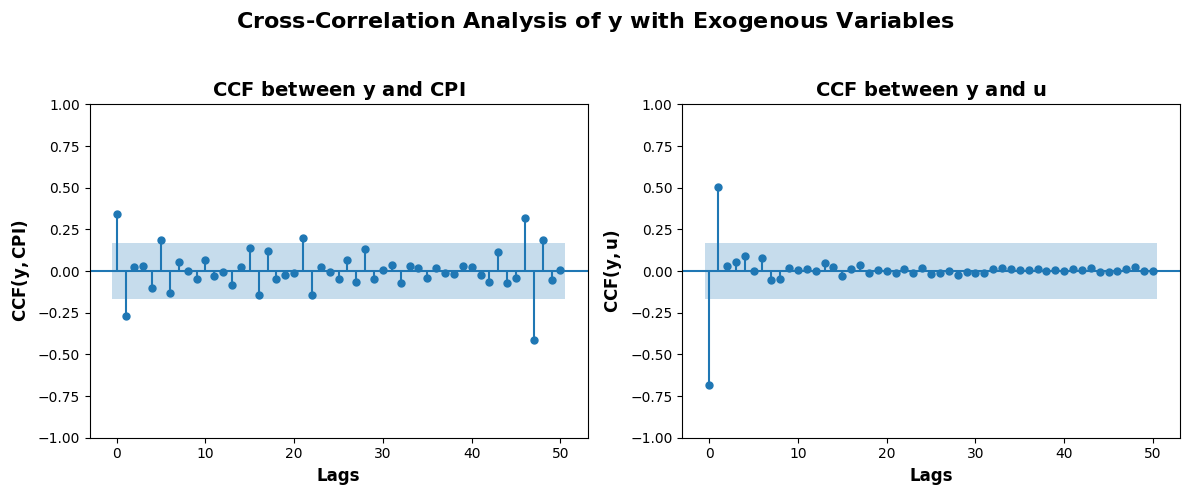

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_ccf(cpi_target, cpi_resid, ax=ax[0], lags=50)
ax[0].set_title(r"CCF between $\mathbf{y}$ and $\mathbf{CPI}$", fontsize=14, weight='bold')
ax[0].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[0].set_ylabel(r"$\mathbf{CCF(y, CPI)}$", fontsize=12, weight='bold')

plot_ccf(u_target, u_resid, ax=ax[1], lags=50)
ax[1].set_title(r"CCF between $\mathbf{y}$ and $\mathbf{u}$", fontsize=14, weight='bold')
ax[1].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[1].set_ylabel(r"$\mathbf{CCF(y, u)}$", fontsize=12, weight='bold')

plt.suptitle(r"Cross-Correlation Analysis of $\mathbf{y}$ with Exogenous Variables", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('./paper/fig/ccf.png', dpi=300)
plt.show()

In [38]:
# Lagged Exog correlations
corr_df = pd.concat([target, cpi, unrate], axis=1)
corr_df.columns = ['y', 'CPI_0', 'u_0']
for lag in range(1, 6):
    corr_df[f'CPI_{lag}'] = cpi.shift(lag)
    corr_df[f'u_{lag}'] = unrate.shift(lag)
corr_df.dropna(inplace=True)
corr_df.corr()['y']


y        1.000000
CPI_0    0.295968
u_0     -0.689899
CPI_1    0.156598
u_1     -0.626441
CPI_2   -0.000961
u_2     -0.230283
CPI_3   -0.191780
u_3      0.514743
CPI_4   -0.148839
u_4      0.295689
CPI_5   -0.006510
u_5     -0.136906
Name: y, dtype: float64

In [39]:
ols = OLS(X, y)
fit = ols.fit(diagnosis_trend="n")
fit.XT_e, fit.beta, fit.coefs, fit.intercept

(np.float64(2.6855687812465945e-16),
 array([ 0.00342017,  0.42887928, -0.24375294,  0.04368188]),
 array([ 0.42887928, -0.24375294,  0.04368188]),
 np.float64(0.003420165236538677))

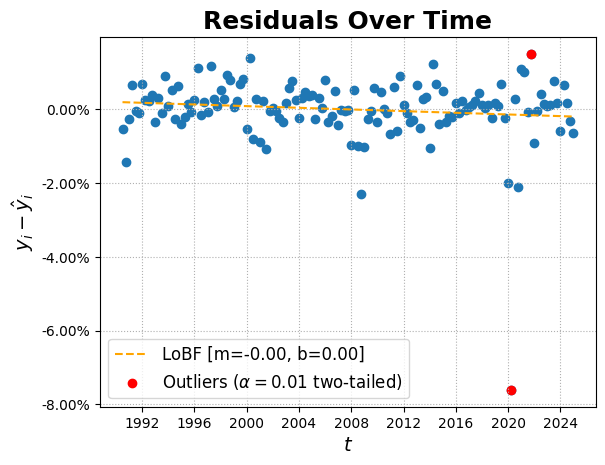

In [40]:
n = len(fit.resid)
x = np.arange(n)
m, b = np.polyfit(x, fit.resid, 1)

line = m * x + b

outliers = np.where((fit.resid < np.quantile(fit.resid, 0.005)) | (fit.resid > np.quantile(fit.resid, 0.995)))[0]

plt.scatter(pd.DatetimeIndex(time_idx), fit.resid)
plt.plot(pd.DatetimeIndex(time_idx), line, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle="--", color="orange")
plt.scatter(pd.DatetimeIndex(time_idx)[outliers], fit.resid[outliers], color='red', label=r'Outliers ($\alpha=0.01$ two-tailed)')


plt.title(r"Residuals Over Time", fontsize=18, weight='bold')
plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$y_i - \hat{y}_i$", fontsize=14)

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(pct_fmt))

plt.grid(alpha=1, linestyle=":")
plt.tick_params(axis="x", rotation=0, labelsize=10)
plt.tick_params(axis="y", rotation=0, labelsize=10)

plt.legend(fontsize=12)
plt.show()

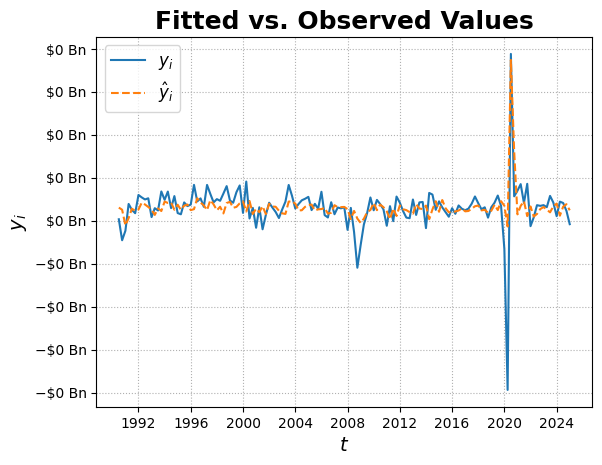

In [41]:
plt.plot(pd.DatetimeIndex(time_idx), y, label=r"$y_i$")
plt.plot(pd.DatetimeIndex(time_idx), fit.fitted_values, label=r"$\hat{y}_i$", linestyle="--")

plt.title(r"Fitted vs. Observed Values", fontsize=18, weight='bold')

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(bn_dollar_fmt))

plt.grid(alpha=1, linestyle=":")
plt.tick_params(axis="x", rotation=0, labelsize=10)
plt.tick_params(axis="y", rotation=0, labelsize=10)

plt.ylabel(r"$y_i$", fontsize=14)
plt.xlabel(r"$t$", fontsize=14)

plt.legend(fontsize=12)
plt.show()

In [42]:
fit.resid_heteroske

reject: False
pval: 0.7844251925783202
test_stat: 4.4634380447165665
stat_name: Breusch-Pagan Test (Chi^2 Statistic)

In [43]:
# print(ols.predict(X_test))
fit.resid_normality

reject: True
pval: 3.5345860675781524e-16
test_stat: 0.67302501325601
stat_name: Shapiro-Wilk Test (Approximated Z-Statistic)

In [44]:
fit.resid_stationarity

reject: True
pval: 0.0011837981414746235
test_stat: -3.244699817628707
stat_name: ADF Test (T-Statistic)

In [45]:
fit.resid_autocorr
all(t.reject == False for t in fit.resid_autocorr)

True

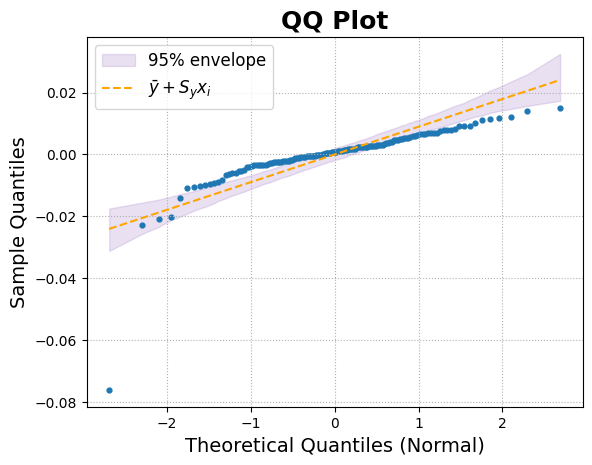

In [46]:
fit.qq(line="45", band=0.95)

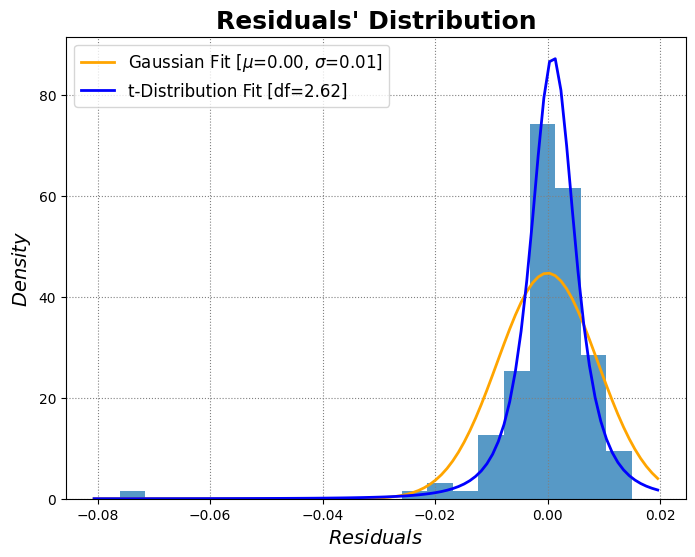

(np.float64(2.6178956228846118),
 np.float64(0.0009408356812343399),
 np.float64(0.004135072656764017))

In [47]:
from scipy.stats import norm, t
fig = plt.figure(figsize=(8,6))
plt.hist(fit.resid, bins=20, density=True, alpha=.75)
mu, std = norm.fit(fit.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

ts = t.fit(fit.resid)
t_fitted = t.pdf(x, ts[0], ts[1], ts[2])


plt.plot(x, p,linewidth=2, label=rf"Gaussian Fit [$\mu$={mu:.2f}, $\sigma$={std:.2f}]", color="orange", linestyle="-")
plt.plot(x, t_fitted, linewidth=2, label=rf"t-Distribution Fit [df={ts[0]:.2f}]", linestyle="-", color="blue")

plt.title(r"Residuals' Distribution", fontsize=18, weight='bold')
plt.xlabel(r"$Residuals$", fontsize=14)
plt.ylabel(r"$Density$", fontsize=14)
plt.grid(alpha=1, linestyle=":", color="gray")
plt.legend(fontsize=12, loc='upper left')
plt.show()

ts

In [48]:
unrate.describe()

,UNRATE
count,420.000000
mean,0.002601
std,0.120319
min,-0.176471
25%,-0.021277
50%,0.000000
75%,0.018182
max,2.363636


In [49]:
sorted(fit.resid_autocorr, key=lambda x: x.pval)

[reject: False
 pval: 0.7342429624943723
 test_stat: 9.989594047220088
 stat_name: BG(8) Test (Chi^2 Statistic),
 reject: False
 pval: 0.7553430012775564
 test_stat: 1.3535583762861325
 stat_name: BG(1) Test (Chi^2 Statistic),
 reject: False
 pval: 0.8117915788226725
 test_stat: 10.006446909993304
 stat_name: BG(7) Test (Chi^2 Statistic),
 reject: False
 pval: 0.8659078254651082
 test_stat: 9.78301507117172
 stat_name: BG(6) Test (Chi^2 Statistic),
 reject: False
 pval: 0.9131994070025042
 test_stat: 9.61833780440201
 stat_name: BG(5) Test (Chi^2 Statistic),
 reject: False
 pval: 0.9265440415241559
 test_stat: 6.9516181697201604
 stat_name: BG(3) Test (Chi^2 Statistic),
 reject: False
 pval: 0.9491744950546707
 test_stat: 9.448060211580007
 stat_name: BG(4) Test (Chi^2 Statistic),
 reject: False
 pval: 0.9552218792491038
 test_stat: 6.212071269903427
 stat_name: BG(2) Test (Chi^2 Statistic)]

In [50]:
pred_set = s.transform(np.array([23_548.210, 323.364, 4.0]).reshape(1, -1))
pred = ols.predict(pred_set)[0]

np.array([pred, (pred - 23_770.98) / 23_770.98 * 100]).round(2)


AssertionError: Scaler is not fitted. Please run .fit before calling .transform or use .fit_transform directly.

In [ ]:
fit.HC_test